## Get Started Adversarial Patch

__Description__:

This notebook demonstrates how to perform an adversarial patch attack on CIFAR-10 data and a simple classification model using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load the data and model
3. Define the patch attack
4. Execute the attack
5. Conclusions
6. Next Steps

## 1. Notebook imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack

from art.attacks.evasion import AdversarialPatchPyTorch
from torchvision import transforms
from torchvision.models import resnet18
from datasets import load_dataset

%matplotlib inline

## 2. Load the data and model

In [2]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

data = load_dataset("CDAO/xview-subset-classification", split="test[11:12]")

model = resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../utils/resources/models/xview_model.pt'))
_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1)
)

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))


Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

## 3. Define the patch attack
In the following cell:
- we set hyperparameters for our patch attack
    - scale_min and scale_max are the max and min values we want our patch to scale to. Smaller patches can be more discrete within an image, but larger patches are more powerful
    - rotation_max is the max value to rotate the patch as in some instances
    - patch_shape is the size of the patch, in this case we have set the patch to be smaller than half the image
    - patch_location is the location of the patch, if not specified, random locations will be used - in this case we have selected the bottom right hand corner of the image
    - targeted is a boolean to indicate if we want the patch to generate a specific target class

In [3]:
batch_size = 16
scale_min = 0.3
scale_max = 1.0
rotation_max = 0
learning_rate = 5000.
max_iter = 400
patch_shape = (3, 50, 50)
patch_location = (0,0)

ap = JaticAttack(AdversarialPatchPyTorch(estimator=jptc, rotation_max=rotation_max, patch_location=patch_location,
                      scale_min=scale_min, scale_max=scale_max, patch_type='circle',
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, verbose=True, targeted=False))

## 4. Execute the attack
In the following cell:
- we extract 10 images from the CIFAR-10 dataset
- as we have defined a targeted adversarial patch attack, we define the target class which we want the patch to force the classifier to predict
- we choose a 'bird' as the target class
- we run the attack, passing in 10 images, and 10 labels of 'bird'
- the output of the attack contains 
    1. the adversarial patch that has been generated (including the mask)
    2. the 10 CIFAR-10 images, with the patch applied at the location we have specified

Example TargetedImageDataset
```python
from typing import Tuple, Dict, Any
class TargetedImageDataset:
    def __init__(self, images):
        self.images = images
    def __len__(self)->int:
        return len(self.images)
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images[ind]["image"]
        return image, 5, None
    
targeted_data = TargetedImageDataset(data)
```

Adversarial Patch PyTorch:   0%|          | 0/400 [00:00<?, ?it/s]

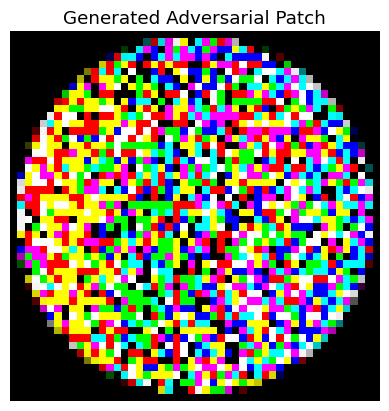

-------------


In [5]:
patched_images, _, metadata = ap(data=data)
patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

## 5. Conclusions
In the following cell:
- we extract the patched images from the output
- loop through the 10 images
- in each case, print the patched image and the predictions for all classes
- we highlight the top prediction
- as expected, in most cases, the prediction is now the target class: 'bird'

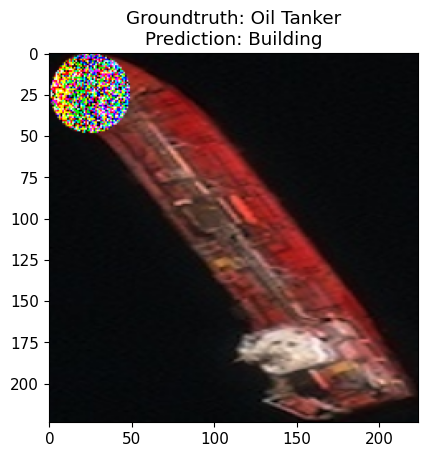

In [12]:
preds = jptc(patched_images)
for i, patched_image in enumerate(patched_images):
    _ = plt.title(f'''Groundtruth: {classes[data[i]["label"]]}\nPrediction: {classes[np.argmax(preds[i])]}''')
    plt.imshow(patched_image.transpose(1,2,0))
    plt.show()

## 6. Next Steps
- Load your own data and model and experiment with the adversarial patch
- Try changing the location and shape of the patch, noting that different locations result in different confidence values
    - Hint: play with locations which fully obscure or slightly cover objects of interest and note the difference when the patch does not cover these objects
- Experimenting with the hyperparameters
    - are circle patches more effective than square patches?
    - what size patches are more effective?
    - if you increase the number of iterations, is the patch more powerful?